# Irrigation Water Balance for Conjuctive Basins
`In this script, we use water balance for conjuctive basins to compute total irrigation (grounwater + surface water) for conjuctive basins.`
- South Platte River Basin, CO
- Pinal AMA, AZ


In [1]:
import ee
import os
from glob import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from stats_ops import calculate_metrics

## Functions

In [2]:
# functions
def gdf_centroids_to_ee_fc(gdf, id_col='ID', centroid_col='centroid'):
    features = []
    for _, row in gdf.iterrows():
        pt = row[centroid_col]
        geom = ee.Geometry.Point(pt.x, pt.y)
        props = {id_col: int(row[id_col])}
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

def sample_imcol_monthly_at_pts(imcol, pts_fc, scale, band_names=None):
    def per_img(img):
        # select bands if provided
        img = img.select(band_names) if band_names else img

        date = img.date()

        # use sampleRegions to extract data
        sampled = img.sampleRegions(collection=pts_fc, 
                                    scale=scale, 
                                    geometries=False  # no need to keep geometry in csv
                                    )
        # add time info
        sampled = sampled.map(
            lambda f: f.set({
                'year': date.get('year'),
                'month': date.get('month')
            })
        )

        return sampled

    # Map over all images and flatten to one collection
    # this return a featurecollection
    return imcol.map(per_img).flatten()

def fc_to_pandas(fc, columns=None, max_rows=50000):
    """
    Converts an ee.FeatureCollection into a pandas DataFrame locally.
    """

    # Convert FC → list of features
    features = fc.limit(max_rows).getInfo()['features']

    # Extract properties
    rows = [f['properties'] for f in features]

    df = pd.DataFrame(rows)

    # Optional: reorder columns
    if columns:
        df = df[columns]

    return df

# __South Platte River Basin, Colorado__

#### Reservoirs' annual net ET loss (ET - precip)

In [3]:
# # load reservoir shapefile and calculate centroids
# rsv = gpd.read_file(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_polygons_south_platte.shp')
# rsv=rsv.dropna()
# spb_river = gpd.read_file(r'E:/westUS_pumping/Data_main/shapefiles/Basins_of_interest/South_Platte_Basin_comparison_extent.shp')

# # calculate centroids for the reservoirs
# rsv = rsv.to_crs('EPSG:4326')
# rsv['centroid'] = rsv['geometry'].centroid

# # plot
# fig, ax = plt.subplots()
# rsv.plot(ax=ax)
# spb_river.plot(ax=ax, facecolor='none', edgecolor='red')                

In [2]:
# # GEE autheticate & initialize
# # ee.Authenticate()
# ee.Initialize(project='ee-fahim', opt_url='https://earthengine-highvolume.googleapis.com')

In [6]:
# # converting reservoir centroids to GEE feature collection
# centroid_fc = gdf_centroids_to_ee_fc(gdf=rsv)

# # OpenET data download
# openET_asset = "OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0"

# openet_df = pd.DataFrame()

# years = list(range(2011, 2024))

# for year in years:
#     if year <= 2021:
        
#         openet_imcol = (ee.ImageCollection(openET_asset)
#                          .filterDate(f'{year}-01-01', f'{year + 3}-01-01'))

#         openet_samples = sample_imcol_monthly_at_pts(imcol=openet_imcol, pts_fc=centroid_fc, 
#                                                  scale=30, band_names=['et_ensemble_mad'])

#         temp_df = fc_to_pandas(openet_samples)

#         openet_df = pd.concat([openet_df, temp_df])

In [7]:
# openet_df = openet_df.drop_duplicates(subset=['ID','year','month'])
# openet_df.to_csv(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_ET.csv', index=False)

In [8]:
# # converting reservoir centroids to GEE feature collection
# centroid_fc = gdf_centroids_to_ee_fc(gdf=rsv)

# # precipitation data download
# prism_asset = "OREGONSTATE/PRISM/ANm"

# prism_df = pd.DataFrame()

# years = list(range(2011, 2024))

# for year in years:
#     if year <= 2021:
        
#         prism_imcol = (ee.ImageCollection(prism_asset)
#                          .filterDate(f'{year}-01-01', f'{year + 3}-01-01'))

#         prism_samples = sample_imcol_monthly_at_pts(imcol=prism_imcol, pts_fc=centroid_fc, 
#                                                  scale=30, band_names=['ppt'])

#         temp_df = fc_to_pandas(prism_samples)

#         prism_df = pd.concat([prism_df, temp_df])

In [9]:
# prism_df  = prism_df.drop_duplicates(subset=['ID','year','month'])
# prism_df.to_csv(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_precip.csv', index=False)

In [10]:
# merge ET_precip_reservoir data together
openet_df = pd.read_csv(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_ET.csv')
prism_df = pd.read_csv(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_precip.csv')

merged_monthly_df = openet_df.merge(prism_df, on=['ID', 'year', 'month'], how='inner')


# merge reservoir area in the dataframe
rsv = gpd.read_file(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_polygons_south_platte.shp')
rsv = rsv[['ID', 'Area_m2']]
merged_monthly_df = merged_monthly_df.merge(rsv, on='ID', how='outer')

# estimate ET and precip volume into acre ft
ACRE_FT = 0.0008107132
vol_df = merged_monthly_df.copy()

vol_df['net_ET_Loss_mm'] = vol_df['et_ensemble_mad'] - vol_df['ppt']
vol_df['net_ET_Loss_AF'] = (vol_df['net_ET_Loss_mm'] * vol_df['Area_m2'] / 1000) * 0.0008107132

In [11]:
# annual calculation of reservoir net ET loss
annual_df = vol_df.groupby('year')['net_ET_Loss_AF'].sum().reset_index()
annual_df.to_csv(r'E:/westUS_pumping/Data_main/pumping/Colorado/raw/reservoir/Reservoir_annual_ET_loss.csv', index=False)
annual_df

,year,net_ET_Loss_AF
0,2011.0,44512.184914
1,2012.0,55034.144412
2,2013.0,44099.087250
3,2014.0,44642.707217
4,2015.0,36258.262423
5,2016.0,53607.266371
6,2017.0,51035.763681
7,2018.0,52735.936810
8,2019.0,44162.065742
9,2020.0,60851.886933


In [12]:
vol_df

,ID,et_ensemble_mad,month,year,ppt,Area_m2,net_ET_Loss_mm,net_ET_Loss_AF
0,1,17.0,1.0,2011.0,4.769000,8.972170e+06,12.231000,88.966540
1,1,15.0,2.0,2011.0,6.549000,8.972170e+06,8.451000,61.471364
2,1,34.0,3.0,2011.0,20.813000,8.972170e+06,13.187000,95.920350
3,1,46.0,4.0,2011.0,47.967999,8.972170e+06,-1.967999,-14.314939
4,1,124.0,5.0,2011.0,166.552002,8.972170e+06,-42.552002,-309.517162
...,...,...,...,...,...,...,...,...
1747,51,147.0,9.0,2023.0,5.393500,1.539387e+07,141.606500,1767.251536
1748,51,78.0,10.0,2023.0,14.885600,1.539387e+07,63.114400,787.668787
1749,51,53.0,11.0,2023.0,8.099100,1.539387e+07,44.900900,560.363996
1750,51,36.0,12.0,2023.0,2.234800,1.539387e+07,33.765200,421.390273


#### Reservoir Diversion & Release data

In [9]:
# compiling all data
all_data = glob(os.path.join(r'E:\westUS_pumping\Data_main\pumping\Colorado\raw\reservoir\all_data\major_reservoir_diversion_release_SPB', '*.csv'))

df = pd.DataFrame()

for data in all_data:
    temp_df = pd.read_csv(data)
    temp_df = temp_df[['WDID', 'Structure Name', 'Irr Year', 'Water Class', 'Annual Total']]
    temp_df = temp_df[temp_df['Irr Year'].isin(list(range(2011, 2024)))]

    df = pd.concat([df, temp_df], axis=0)

# separating the diversions and release in separate columns
df_pivot = df.pivot(index=['WDID', 'Structure Name', 'Irr Year'],
                    columns='Water Class',
                    values='Annual Total').reset_index()
df_pivot = df_pivot.fillna(0)

df_pivot

Water Class,WDID,Structure Name,Irr Year,Total (Diversions),Total (Releases)
0,103570,BIJOU RES 2,2011,12013.97,1571.37
1,103570,BIJOU RES 2,2012,2219.73,185.25
2,103570,BIJOU RES 2,2013,14683.32,0.00
3,103570,BIJOU RES 2,2014,12458.62,327.56
4,103570,BIJOU RES 2,2015,8997.61,0.00
...,...,...,...,...,...
134,6403906,JULESBURG RES,2019,18748.01,0.00
135,6403906,JULESBURG RES,2020,11886.84,5499.79
136,6403906,JULESBURG RES,2021,25256.81,17256.46
137,6403906,JULESBURG RES,2022,23400.96,16926.50


In [10]:
df_annual = df_pivot.groupby('Irr Year')[['Total (Diversions)', 'Total (Releases)']].sum().reset_index()
df_annual.to_csv(r'E:\westUS_pumping\Data_main\pumping\Colorado\Final\Major_reservoir_annual_diversion_release_SPB.csv', index=False)
df_annual

Water Class,Irr Year,Total (Diversions),Total (Releases)
0,2011,333244.51,117659.54
1,2012,216125.79,226445.24
2,2013,439596.74,185202.45
3,2014,397536.16,185620.20
4,2015,287924.26,194786.91
5,2016,314593.92,202477.81
6,2017,399852.22,194643.25
7,2018,327449.85,200240.20
8,2019,399572.60,169944.02
9,2020,286496.07,229521.49


### Water balance to calculte total irrigation

In [4]:
# reading and selecting actual and predicted pumping for South Platte
spb_df = pd.read_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\annual_pumping_ML_v11.csv')

spb_df = spb_df[['basin_code', 'year', 'mean pred_pumping_mm', 'mean low_mm', 
                 'mean high_mm', 'mean actual_pumping_mm']]

spb_df = spb_df.rename(columns={'mean pred_pumping_mm': 'predicted pumping_mm', 
                                'mean low_mm': 'low CI_mm', 'mean high_mm': 'high CI_mm', 
                                'mean actual_pumping_mm': 'actual pumping_mm'})

spb_df = spb_df[(spb_df.loc[:, 'basin_code'] == 'spb') & (spb_df.loc[:, 'year'].isin(list(range(2011, 2024))))]

# diversion and rechrage data 
df2 = pd.read_csv(r'E:\westUS_pumping\Data_main\pumping\Colorado\Final\SW_SouthPlatte.csv')
df2 = df2[['year','diversion_AF', 'recharge_AF']]

# reservoir diversion and release data
df3 = pd.read_csv(r'E:\westUS_pumping\Data_main\pumping\Colorado\Final\Major_reservoir_annual_diversion_release_SPB.csv')
df3 = df3.rename(columns={'Irr Year': 'year'})

# merge informations
merged_df = spb_df.merge(df2, on='year')
merged_df = merged_df.merge(df3, on='year')

merged_df.head()

,basin_code,year,predicted pumping_mm,low CI_mm,high CI_mm,actual pumping_mm,diversion_AF,recharge_AF,Total (Diversions),Total (Releases)
0,spb,2011,111.635920,107.483837,115.788003,27.533862,1.135304e+06,243581.2765,333244.51,117659.54
1,spb,2012,128.705588,123.831749,133.579427,50.345344,1.044957e+06,137600.3504,216125.79,226445.24
2,spb,2013,107.067611,103.492624,110.642598,35.127183,1.197218e+06,160550.8524,439596.74,185202.45
3,spb,2014,108.025671,104.024248,112.027095,32.874175,1.607621e+06,326488.8377,397536.16,185620.20
4,spb,2015,79.157500,75.833503,82.481497,37.559008,1.255251e+06,272207.1834,287924.26,194786.91


In [5]:
# release to river from reservoirs (constant value)
# estimated using reported values (and assumptions) in South Platte decision support model
merged_df['aug_to_river_from_res'] = 44740.50

# 23% conveyance loss (canal seepage) of total diverted water
merged_df['diversion_after_seepage_AF'] = merged_df['diversion_AF'] * 0.77

# SW irrigation from direct diversion from South Platte
merged_df['SW_Irr_direct_AF'] = merged_df['diversion_after_seepage_AF'] - merged_df['recharge_AF'] - merged_df['Total (Diversions)']

# SW irrigation from reservoirs
# we consider 23% conveyance loss here as well
merged_df['SW_Irr_reservoirs_AF'] =  0.77* (merged_df['Total (Releases)'] - merged_df['aug_to_river_from_res'])

# total SW irrigation
spb_area = 7189173178.537 * (1000 * 1000)  # unit m2

merged_df['SW_Irr_total_AF'] = merged_df['SW_Irr_direct_AF'] + merged_df['SW_Irr_reservoirs_AF']
merged_df['SW_Irr_total_mm'] = merged_df['SW_Irr_total_AF'] * 1233481837547.5 / spb_area

# total irrigation (SW irrigation + Actual pumping)
merged_df['total_Irr_mm (SW + GW)'] = merged_df['SW_Irr_total_mm'] + merged_df['actual pumping_mm'] 

# save csv
merged_df.to_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\South_platte_total_Irr_balance.csv', index=False)

merged_df.head()

,basin_code,year,predicted pumping_mm,low CI_mm,high CI_mm,actual pumping_mm,diversion_AF,recharge_AF,Total (Diversions),Total (Releases),aug_to_river_from_res,diversion_after_seepage_AF,SW_Irr_direct_AF,SW_Irr_reservoirs_AF,SW_Irr_total_AF,SW_Irr_total_mm,total_Irr_mm (SW + GW)
0,spb,2011,111.635920,107.483837,115.788003,27.533862,1.135304e+06,243581.2765,333244.51,117659.54,44740.5,8.741844e+05,297358.663023,56147.6608,353506.323823,60.652820,88.186682
1,spb,2012,128.705588,123.831749,133.579427,50.345344,1.044957e+06,137600.3504,216125.79,226445.24,44740.5,8.046166e+05,450890.464161,139912.6498,590803.113961,101.366999,151.712343
2,spb,2013,107.067611,103.492624,110.642598,35.127183,1.197218e+06,160550.8524,439596.74,185202.45,44740.5,9.218578e+05,321710.257205,108155.7015,429865.958705,73.754219,108.881402
3,spb,2014,108.025671,104.024248,112.027095,32.874175,1.607621e+06,326488.8377,397536.16,185620.20,44740.5,1.237868e+06,513842.983111,108477.3690,622320.352111,106.774567,139.648742
4,spb,2015,79.157500,75.833503,82.481497,37.559008,1.255251e+06,272207.1834,287924.26,194786.91,44740.5,9.665434e+05,406411.962505,115535.7357,521947.698205,89.553136,127.112145


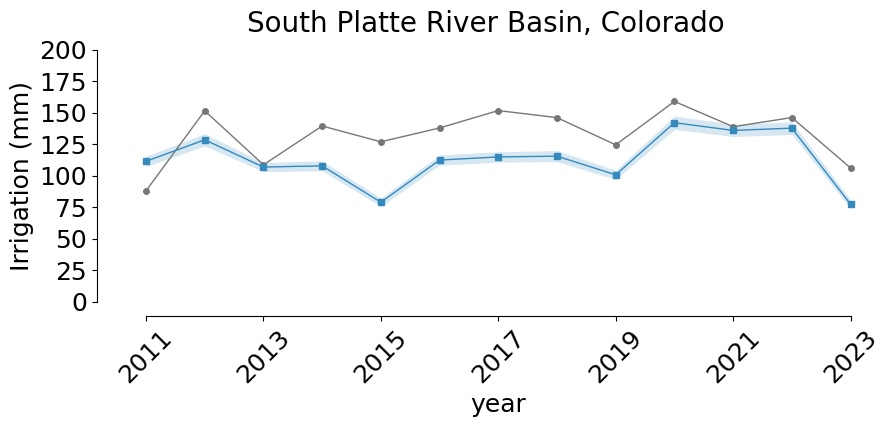

In [6]:
# plotting
import pandas as pd
from plots import make_line_plot_with_error

df = pd.read_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\South_platte_total_Irr_balance.csv')

save_path = '../../Model_run/plots/time_series_all/spb.jpg'

# plot
make_line_plot_with_error(y_series=[df['total_Irr_mm (SW + GW)'],
                                    df['predicted pumping_mm'],],
                          year=df['year'], 
                          fontsize=18, xlabel='year', ylabel='Irrigation (mm)',
                          line_labels=['actual total irrigation', 'total irrigation'],   
                          low_CI=[None, df['low CI_mm']], 
                          high_CI=[None, df['high CI_mm']],
                          savepath=save_path, 
                          figsize=(10, 4), y_lim=(0, 200),
                          colors=["#777777", "#348ABD"], 
                          markers=None, legend_pos='lower left',
                          legend='off', no_xticks=False,
                          alpha_band=0.2, suptitle='South Platte River Basin, Colorado')

In [7]:
error_dict = calculate_metrics(predictions=df['predicted pumping_mm'], targets=df['total_Irr_mm (SW + GW)'])
       
print('South Platte comparison stats:')
print(error_dict)

South Platte comparison stats:
{'RMSE': 26.42805356824138, 'MAE': 23.192593070823854, 'R2': -0.7274173428114192, 'Normalized RMSE': 0.19888504157947354, 'Normalized MAE': 0.17453649491499632, 'PBIAS': 14.738758987770236}


--------------------

# __Pinal AMA, Arizona__

#### Water balance to calculte total irrigation

In [8]:
# reading and selecting actual and predicted pumping for Pinal AMA
pnl_df = pd.read_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\annual_pumping_ML_v11.csv')

pnl_df = pnl_df[['basin_code', 'year', 'mean pred_pumping_mm', 'mean low_mm', 
                 'mean high_mm', 'mean actual_pumping_mm']]

pnl_df = pnl_df.rename(columns={'mean pred_pumping_mm': 'predicted pumping_mm', 
                                'mean low_mm': 'low CI_mm', 'mean high_mm': 'high CI_mm', 
                                'mean actual_pumping_mm': 'actual pumping_mm'})

pnl_df = pnl_df[(pnl_df.loc[:, 'basin_code'] == 'pnl') & (pnl_df.loc[:, 'year'].isin(list(range(2000, 2024))))]

# surface water irrigation data
df4 = pd.read_csv(r'E:\westUS_pumping\Data_main\pumping\Arizona\Final\SW_Pinal.csv')

# merge informations
merged_df2 = pnl_df.merge(df4, on='year')

merged_df2.head()

,basin_code,year,predicted pumping_mm,low CI_mm,high CI_mm,actual pumping_mm,Colorado River,Effluent,Groundwater,Surface
0,pnl,2000,67.242774,63.984163,70.501385,41.431860,282101,1625,500576,25807
1,pnl,2001,68.131123,65.025103,71.237143,34.888341,282393,1585,445312,101430
2,pnl,2002,68.571859,64.648968,72.494751,41.524601,296062,1550,534505,38062
3,pnl,2003,68.721243,64.926576,72.515910,50.469255,332470,1789,494337,16858
4,pnl,2004,68.870359,65.517921,72.222798,48.508861,295613,1608,490205,22084


In [9]:
# total SW irrigation
pnl_area = 10614105343.818 * (1000 * 1000)  # unit m2

merged_df2['total_SW_AF'] = merged_df2['Colorado River'] + merged_df2['Effluent'] + merged_df2['Surface']
merged_df2['total_SW_mm'] = merged_df2['total_SW_AF'] * 1233481837547.5 / pnl_area

# 15% conveyance loss (canal seepage) of total diverted water
merged_df2['SW_Irr_after_conveyance_loss_mm'] = merged_df2['total_SW_mm'] * 0.85

# total irrigation
merged_df2['total_Irr_mm (SW + GW)'] = merged_df2['SW_Irr_after_conveyance_loss_mm'] + merged_df2['actual pumping_mm'] 

# save csv
merged_df2.to_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\Pinal_AMA_total_Irr_balance.csv', index=False)

merged_df2.head()

,basin_code,year,predicted pumping_mm,low CI_mm,high CI_mm,actual pumping_mm,Colorado River,Effluent,Groundwater,Surface,total_SW_AF,total_SW_mm,SW_Irr_after_conveyance_loss_mm,total_Irr_mm (SW + GW)
0,pnl,2000,67.242774,63.984163,70.501385,41.431860,282101,1625,500576,25807,309533,35.971316,30.575618,72.007478
1,pnl,2001,68.131123,65.025103,71.237143,34.888341,282393,1585,445312,101430,385408,44.788868,38.070538,72.958879
2,pnl,2002,68.571859,64.648968,72.494751,41.524601,296062,1550,534505,38062,335674,39.009202,33.157822,74.682423
3,pnl,2003,68.721243,64.926576,72.515910,50.469255,332470,1789,494337,16858,351117,40.803858,34.683279,85.152534
4,pnl,2004,68.870359,65.517921,72.222798,48.508861,295613,1608,490205,22084,319305,37.106935,31.540895,80.049756


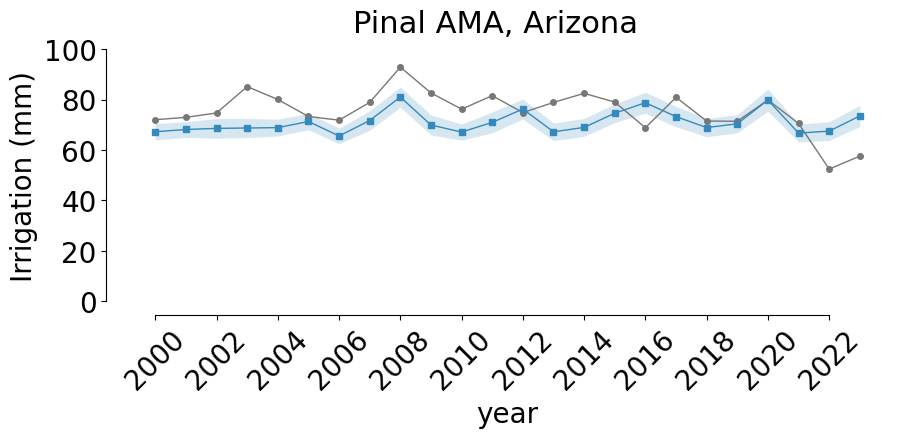

In [10]:
# plotting
import pandas as pd
from plots import make_line_plot_with_error

df = pd.read_csv(r'E:\westUS_pumping\Model_run\basin_comparison_results\Pinal_AMA_total_Irr_balance.csv')

save_path = '../../Model_run/plots/time_series_all/pnl.jpg'

# plot
make_line_plot_with_error(y_series=[df['total_Irr_mm (SW + GW)'],
                                    df['predicted pumping_mm'],],
                          year=df['year'], 
                          fontsize=20, xlabel='year', ylabel='Irrigation (mm)',
                          line_labels=['actual total irrigation', 'predicted total irrigation'],   
                          low_CI=[None, df['low CI_mm']], 
                          high_CI=[None, df['high CI_mm']],
                          savepath=save_path, 
                          figsize=(10, 4), y_lim=(0, 100),
                          colors=["#777777", "#348ABD"], 
                          markers=None, legend_pos='lower left',
                          legend='off', no_xticks=False,
                          alpha_band=0.2, suptitle='Pinal AMA, Arizona')

In [11]:
error_dict = calculate_metrics(predictions=df['predicted pumping_mm'], targets=df['total_Irr_mm (SW + GW)'])
       
print('Pinal AMA comparison stats:')
print(error_dict)

Pinal AMA comparison stats:
{'RMSE': 9.29239552688784, 'MAE': 7.921503301773143, 'R2': -0.2711641040300721, 'Normalized RMSE': 0.12319465374250539, 'Normalized MAE': 0.10501994384099299, 'PBIAS': 5.820496681692912}
